## Imports

In [289]:
import numpy as np
import einops
import copy
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

import importlib
import pickle
from datetime import datetime

In [290]:
import bonds
import lattice
import utils
import plot_utils

In [291]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)
plot_utils = importlib.reload(plot_utils)


## Set up lattice

### Kagome bow tie

In [292]:
# lattice params for kagome lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

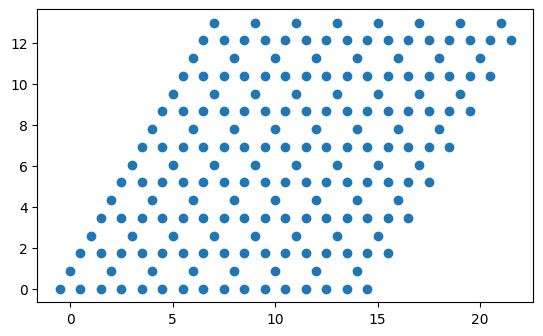

In [293]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [294]:
height = np.sqrt(3)/2
# polygon = lattice.create_hexagon(5.1, 7, 5 * height)
polygon = lattice.create_hexagon(6.1, 10, 7 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

# ebSpecs = bonds.Bonds(
#     polygon_ebs = [
#         polygon, polygon, polygon, polygon, polygon, polygon
#     ], 
#     unit_cell_bases_ebs = [
#         np.array([0, height]), 
#         np.array([1.5, 0.]),
#         np.array([0.5, 0.]),
#         np.array([0., height]),
#         np.array([-0.5, 0.]),
#         np.array([0.5, 0.]),
#     ]    
# )

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        polygon, polygon, polygon, polygon, 
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0.5, 0.]), 
    ]    
)

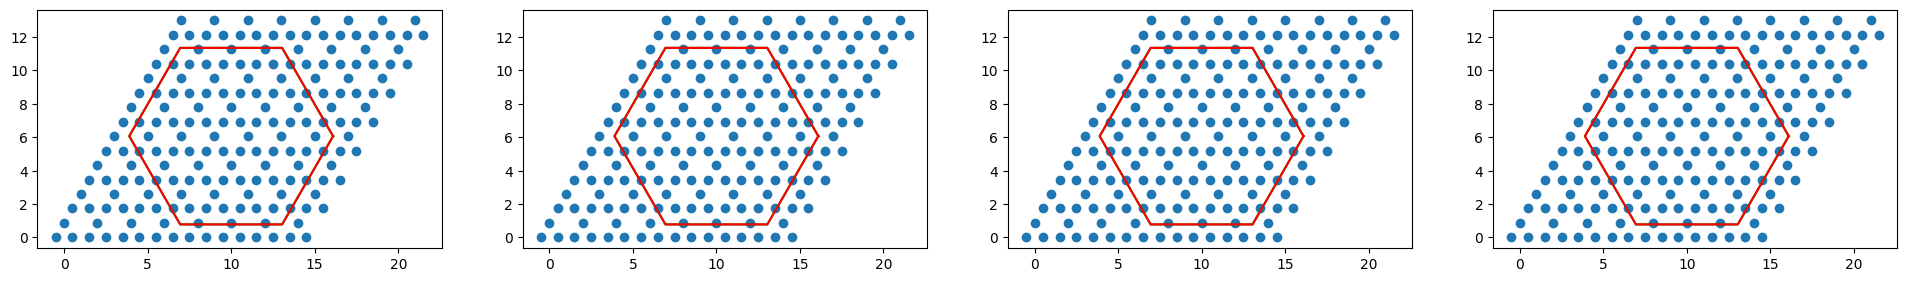

In [295]:
num_configs_loop = len(ebSpecs.polygon_ebs)
fig, axes = plt.subplots(1, num_configs_loop, figsize=(6 *num_configs_loop, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [296]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

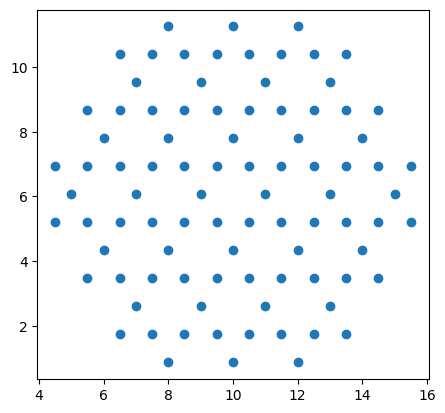

In [297]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=90 and $N_{\\rm bonds}=$162')

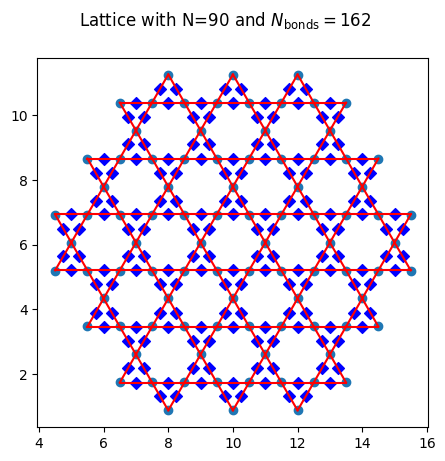

In [299]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.scatter(*bonds_mid.T, marker='D', c='b')
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [300]:
#@title get rydberg bonds
ryd_bonds_indices = bonds._get_ryd_bonds(bonds_nn, [(0.5 + 0.1, 0.), (height+0.01, 0.6), (1.1, height+0.01) ])
print(f" indices are {[ryd_bonds_indices[i].shape for i in range(len(ryd_bonds_indices))]}")
ryd_bonds = [bonds_nn[indices] for indices in ryd_bonds_indices]   #[(M, 2, 2, 2) array for each bond type] each term has 2 bonds
print(f" bonds shape are {[ryd_bonds[i].shape for i in range(len(ryd_bonds))]}")

 indices are [(162, 2), (144, 2), (144, 2)]
 bonds shape are [(162, 2, 2, 2), (144, 2, 2, 2), (144, 2, 2, 2)]


Text(0.5, 0.98, 'Rydberg blockade bonds for 5 random bonds and 3 nn-bond types')

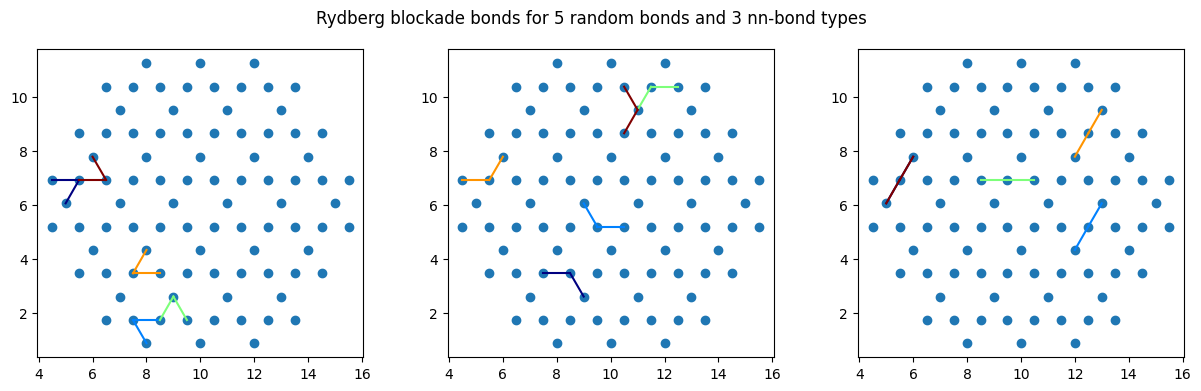

In [301]:
fig, axes = plt.subplots(1, len(ryd_bonds), figsize=(5 * len(ryd_bonds), 4))
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
num_rand = 5
colors = plt.cm.jet(np.linspace(0, 1, num_rand))

for k, k_bonds in enumerate(ryd_bonds):
    rand_idx = np.random.randint(0, k_bonds.shape[0], num_rand) # generate random indices to plot
    ax = axes[k]
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")    
    
    for i, j in enumerate(rand_idx):
        # print(i, j)
        # print(f"k vonds shape is {k_bonds.shape}")
        plot_utils._plot_v_bonds(ax, k_bonds[j, ], c=colors[i, ])

plt.suptitle(f"Rydberg blockade bonds for {num_rand} random bonds and {len(ryd_bonds)} nn-bond types")



In [302]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

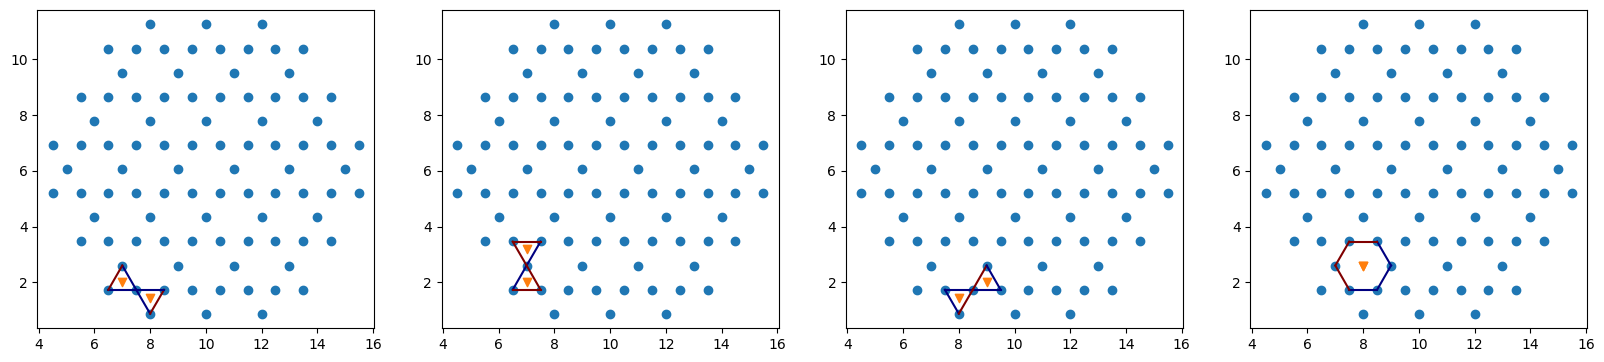

In [303]:
num_config_loops = len(ebSpecs.unit_cell_bases_ebs)
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs[:1]):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

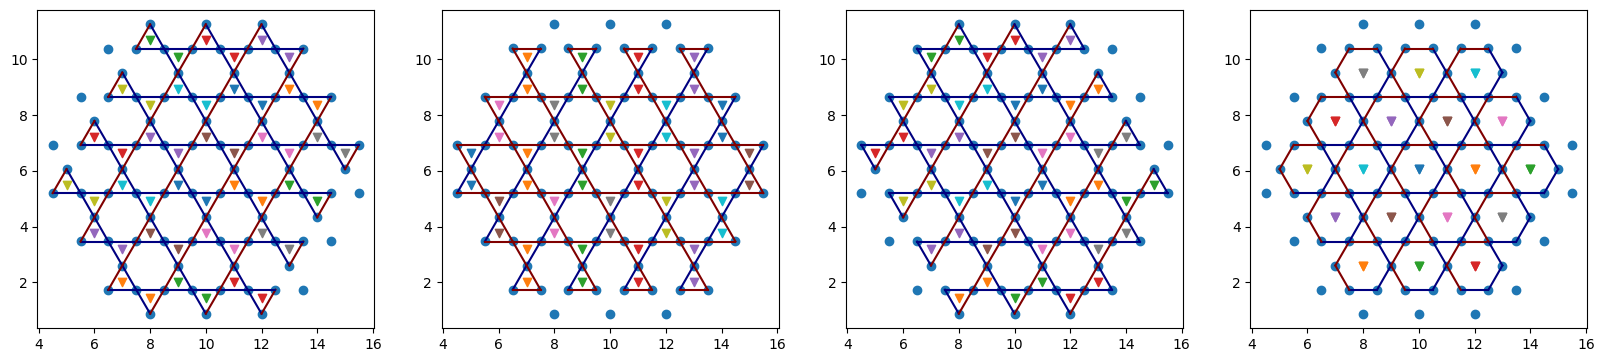

In [304]:
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=90 and $N_{\\rm bonds}=$162')

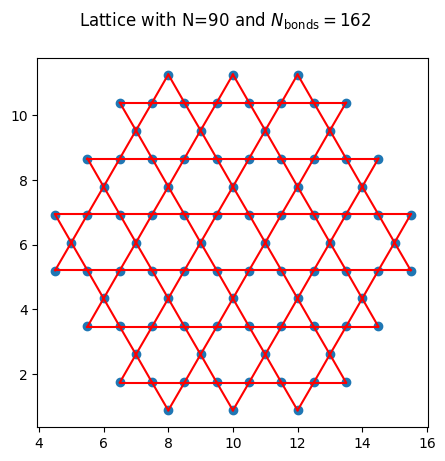

In [305]:
bonds_3nn = bonds._find_all_bonds(BZ_kpoints_cut[:, :], 1.1)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_3nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_3nn.shape[0]}")


In [306]:
bonds_3nn.shape

(162, 2, 2)

In [307]:
bonds_nn.shape

(162, 2, 2)

#### Saddle point 

In [308]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [309]:
list(bonds_dict.keys())[0]

'[[7.5  1.73]\n [6.5  1.73]]'

In [310]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
# energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
energy_Q = lambda Q_init: utils.get_energy_rydberg(couplings, Q_init, Q0, ListEBs, ryd_bonds, bonds_dict)


In [311]:
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5 * np.ones_like(Q_init))
results_gs = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_gs = minimize(energy_Q, Q_init)

`gtol` termination condition is satisfied.
Number of iterations: 154, function evaluations: 24776, CG iterations: 3696, optimality: 8.33e-09, constraint violation: 0.00e+00, execution time: 1.7e+03 s.


In [312]:
time_today = datetime.today().strftime('%Y-%m-%d')
pickle.dump(results_gs, open(f"results_gs_ryd_{time_today}.p", "wb"))

In [313]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-974.9836240819237
True
`gtol` termination condition is satisfied.
1


array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

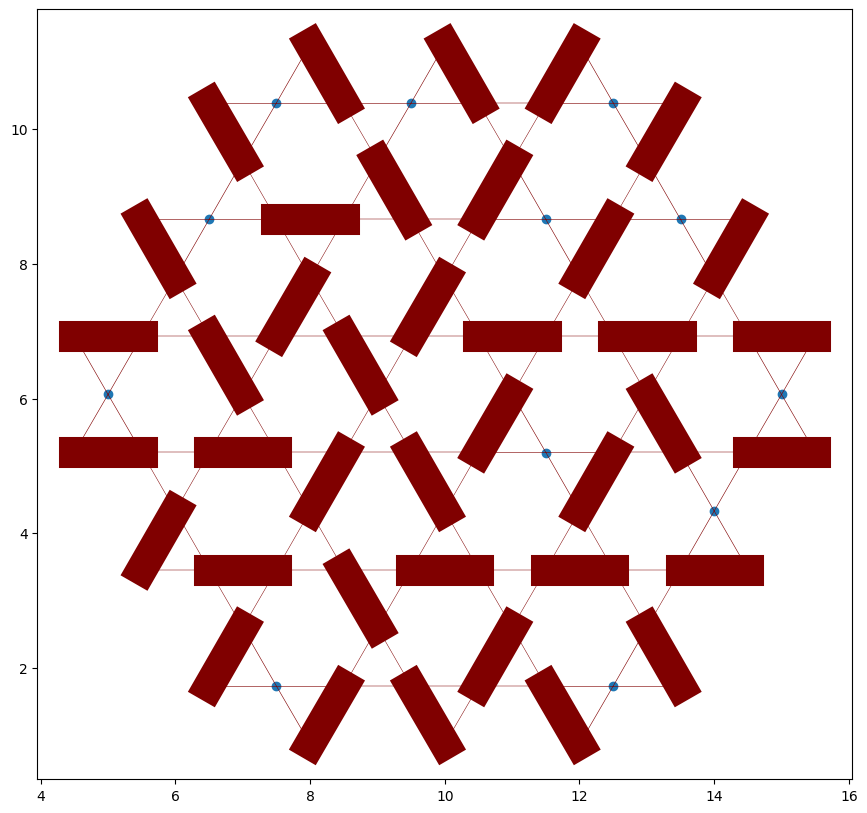

In [314]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$\bar{Q}^0=$" + f"{np.mean(results_gs['x']):.2f}", (2., 5.5), size=25)
  # ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison pairs


In [315]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    # v_pt=np.array([11, 19/3 * height]),
    v_pt=np.array([[11, 8],[5 * height, 25/3 * height]]),
    visonBonds_vs = [
                 np.array([[7.5, 8 * height], [8.5, 8. * height]]), 
              np.array([[8.5, 8. * height], [9.,  7 * height]]), 
              np.array([[9.,  7 * height], [9.5, 8 *height]]), 
              np.array([[10.5, 6 *height], [11, 7 * height]]),
                     np.array([[10.5, 6 *height], [11.5, 6 * height]]),
              ]
)              
visonBonds_idx = []
# print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

# print(f"final value of Q_init is {Q_init}")

In [316]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

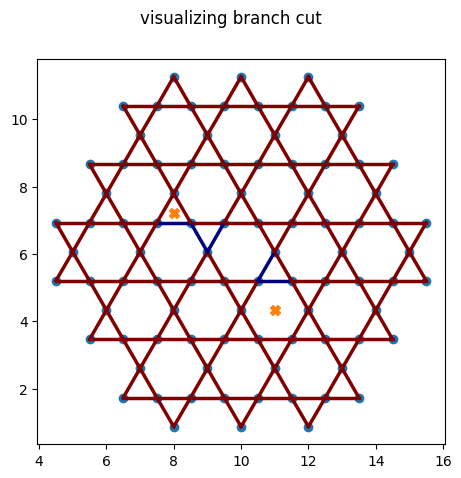

In [317]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [318]:
results_gs['x']

array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

In [319]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy_rydberg(couplings, Q_init_vs, Q0, ListEBs, ryd_bonds,bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 2119, CG iterations: 18, optimality: 9.77e-10, constraint violation: 0.00e+00, execution time: 1e+02 s.


In [320]:
energy_Q(Q_init)

261.5

In [321]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-974.9966565121944
True
`gtol` termination condition is satisfied.
1


array([ 8.25149402e-04,  8.25149771e-04,  8.24902527e-04,  8.25202341e-04,
        5.86022707e-04,  5.86037349e-04,  4.99999667e+00,  5.86022932e-04,
        5.86023006e-04,  8.25096766e-04,  4.99999667e+00,  5.86023217e-04,
        8.24902527e-04,  4.99999667e+00,  5.86023252e-04,  4.99999667e+00,
        5.86022996e-04,  5.86023575e-04,  5.86023166e-04,  5.86013934e-04,
        4.99999667e+00,  5.86023012e-04,  4.99999667e+00,  5.86023074e-04,
        5.86023053e-04,  5.86013874e-04,  4.99999667e+00,  5.86038181e-04,
        5.86037966e-04,  5.86022856e-04,  4.99999667e+00,  8.24848883e-04,
        4.99999667e+00,  5.86023600e-04,  5.86022962e-04,  8.25255102e-04,
        4.99999667e+00,  5.86022917e-04,  5.85944095e-04,  5.86023044e-04,
        5.85999205e-04,  5.86012884e-04,  4.99999667e+00,  5.86022930e-04,
       -8.25255397e-04,  8.25430821e-04,  8.26614917e-04,  8.25255689e-04,
        5.86023153e-04,  5.86023169e-04,  8.24919045e-04,  4.99999667e+00,
        4.99999667e+00,  

In [322]:
time_today = datetime.today().strftime('%Y-%m-%d')
pickle.dump(results_vison, open(f"results_vison_pair_ryd_{time_today}.p", "wb"))

In [323]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [324]:
results_gs['x']

array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

In [325]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [326]:
Q0_results

array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

In [327]:
Q_init_vs

array([ 1.84211623e-03,  1.83644752e-03,  1.84242859e-03,  1.84004187e-03,
        1.28956729e-03,  1.28191044e-03,  4.99998359e+00,  1.28928333e-03,
        1.28950949e-03,  1.84242998e-03,  4.99998361e+00,  1.28960255e-03,
        1.84242450e-03,  4.99998361e+00,  1.28927290e-03,  4.99998355e+00,
        1.28953460e-03,  1.28609144e-03,  1.28862648e-03,  1.26995747e-03,
        4.99998361e+00,  1.28945525e-03,  4.99998358e+00,  1.28946549e-03,
        1.28958775e-03,  1.27194615e-03,  4.99998360e+00,  1.28188061e-03,
        1.28023921e-03,  1.28950824e-03,  4.99998350e+00,  1.84078814e-03,
        4.99998352e+00,  1.28602300e-03,  1.28958701e-03,  1.83386025e-03,
        4.99998361e+00,  1.28923833e-03,  1.28739928e-03,  1.28954306e-03,
        1.28009798e-03,  1.27792892e-03,  4.99998349e+00,  1.28943103e-03,
       -1.84242952e-03,  1.83895479e-03,  1.79894714e-03,  1.84257010e-03,
        1.28955319e-03,  1.28916842e-03,  1.83852395e-03,  4.99998361e+00,
        4.99998361e+00,  

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

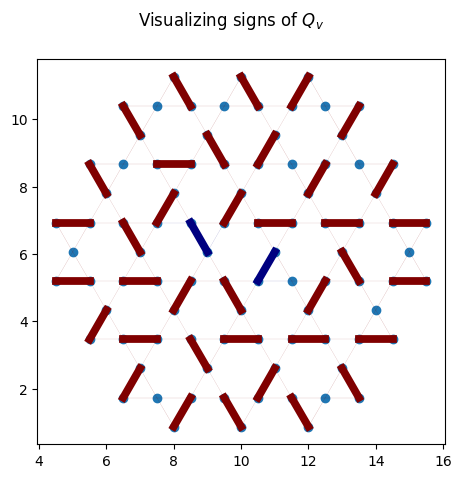

In [328]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [329]:
Qv_results - Q0_results

array([-1.01696682e-03, -1.01129774e-03, -1.01752607e-03, -1.01483953e-03,
       -7.03544581e-04, -6.95873095e-04,  1.30854867e-05, -7.03260396e-04,
       -7.03486485e-04, -1.01733321e-03,  1.30602525e-05, -7.03579329e-04,
       -1.01752197e-03,  1.30603714e-05, -7.03249643e-04,  1.31192082e-05,
       -7.03511604e-04, -7.00067860e-04, -7.02603310e-04, -6.83943540e-04,
        1.30616454e-05, -7.03432238e-04,  1.30940678e-05, -7.03442416e-04,
       -7.03564700e-04, -6.85932271e-04,  1.30757410e-05, -6.95842428e-04,
       -6.94201240e-04, -7.03485387e-04,  1.31708868e-05, -1.01593926e-03,
        1.31564008e-05, -6.99999397e-04, -7.03564044e-04, -1.00860515e-03,
        1.30624477e-05, -7.03215410e-04, -7.01455181e-04, -7.03520012e-04,
       -6.94098779e-04, -6.91916039e-04,  1.31828073e-05, -7.03408105e-04,
       -2.66768492e-03, -1.01352397e-03, -9.72332224e-04, -1.01731441e-03,
       -7.03530035e-04, -7.03145248e-04, -1.01360490e-03,  1.30587024e-05,
        1.30611018e-05, -

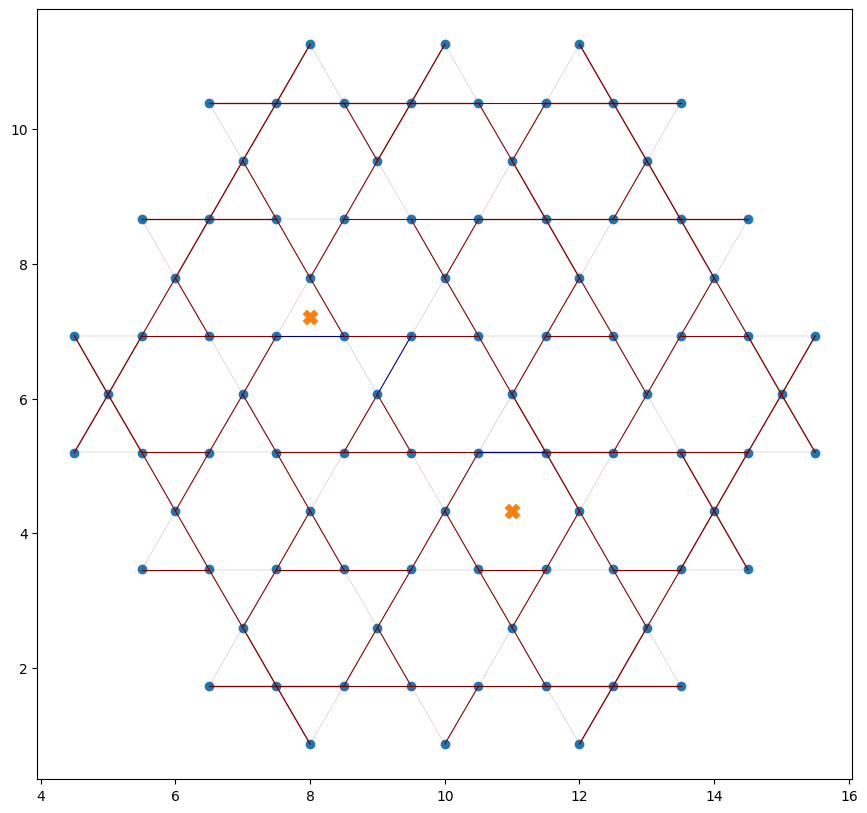

In [330]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison


In [331]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    v_pt=np.array([10, 7 * height]),
    visonBonds_vs = [np.array([[10.5, 6 * height], [11., 7 * height]]),
                 np.array([[10.5, 6 * height], [11.5, 6. * height]]), 
              np.array([[11.5, 6. * height], [12.,  5 * height]]), 
              np.array([[12.,  5 * height], [12.5, 6 *height]]), 
              np.array([[13.5, 4 *height], [14, 5 * height]]),
                     np.array([[13.5, 4 *height], [14.5, 4 * height]]),
              ]
)              
visonBonds_idx = []
print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

print(f"final value of Q_init is {Q_init}")

initial value of Q_init is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
final value of Q_init is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

In [332]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

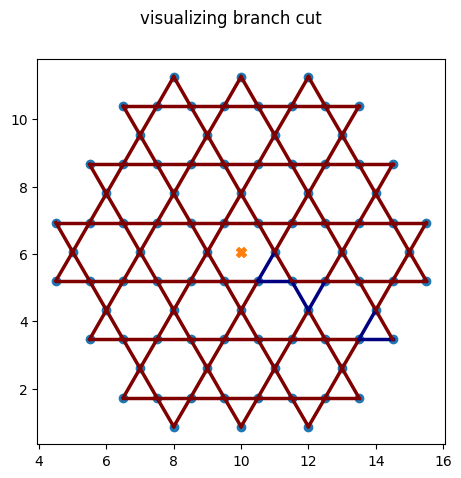

In [333]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [334]:
results_gs['x']

array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

In [335]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy_rydberg(couplings, Q_init_vs, Q0, ListEBs, ryd_bonds, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 2119, CG iterations: 18, optimality: 9.69e-10, constraint violation: 0.00e+00, execution time: 1.1e+02 s.


In [336]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [337]:
results_gs['x']

array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

In [338]:
energy_Q(Q_init)

261.5

In [339]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-974.9966567878174
True
`gtol` termination condition is satisfied.
1


array([ 8.25187885e-04,  8.25170196e-04,  8.25011354e-04,  8.25170136e-04,
        5.85962153e-04,  5.85963027e-04,  4.99999667e+00,  5.85962008e-04,
        5.85961887e-04,  8.25134374e-04,  4.99999667e+00,  5.85961881e-04,
        8.25011305e-04,  4.99999667e+00,  5.85937527e-04,  4.99999667e+00,
        5.85962306e-04,  5.85962384e-04,  5.85961835e-04,  5.85927830e-04,
        4.99999667e+00,  5.85961727e-04,  4.99999667e+00,  5.85962144e-04,
        5.85961982e-04,  5.85913481e-04,  4.99999667e+00,  5.85962949e-04,
        5.85938368e-04,  5.85961854e-04, -4.99999667e+00,  8.24904655e-04,
        4.99999667e+00,  5.85962376e-04,  5.85962169e-04,  8.25117933e-04,
        4.99999667e+00,  5.85962227e-04,  5.85937772e-04,  5.85962228e-04,
        5.85937271e-04,  5.85937437e-04,  4.99999667e+00,  5.85962160e-04,
       -8.25275856e-04,  8.25468257e-04, -8.26476626e-04,  8.25293306e-04,
        5.85962299e-04,  5.85962088e-04,  8.24957965e-04,  4.99999667e+00,
        4.99999667e+00,  

In [340]:
time_today = datetime.today().strftime('%Y-%m-%d')
pickle.dump(results_vison, open(f"results_vison_ryd_{time_today}.p", "wb"))

In [341]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [342]:
Q0_results

array([1.84211623e-03, 1.83644752e-03, 1.84242859e-03, 1.84004187e-03,
       1.28956729e-03, 1.28191044e-03, 4.99998359e+00, 1.28928333e-03,
       1.28950949e-03, 1.84242998e-03, 4.99998361e+00, 1.28960255e-03,
       1.84242450e-03, 4.99998361e+00, 1.28927290e-03, 4.99998355e+00,
       1.28953460e-03, 1.28609144e-03, 1.28862648e-03, 1.26995747e-03,
       4.99998361e+00, 1.28945525e-03, 4.99998358e+00, 1.28946549e-03,
       1.28958775e-03, 1.27194615e-03, 4.99998360e+00, 1.28188061e-03,
       1.28023921e-03, 1.28950824e-03, 4.99998350e+00, 1.84078814e-03,
       4.99998352e+00, 1.28602300e-03, 1.28958701e-03, 1.83386025e-03,
       4.99998361e+00, 1.28923833e-03, 1.28739928e-03, 1.28954306e-03,
       1.28009798e-03, 1.27792892e-03, 4.99998349e+00, 1.28943103e-03,
       1.84242952e-03, 1.83895479e-03, 1.79894714e-03, 1.84257010e-03,
       1.28955319e-03, 1.28916842e-03, 1.83852395e-03, 4.99998361e+00,
       4.99998361e+00, 1.84197280e-03, 4.99998360e+00, 1.84100197e-03,
      

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

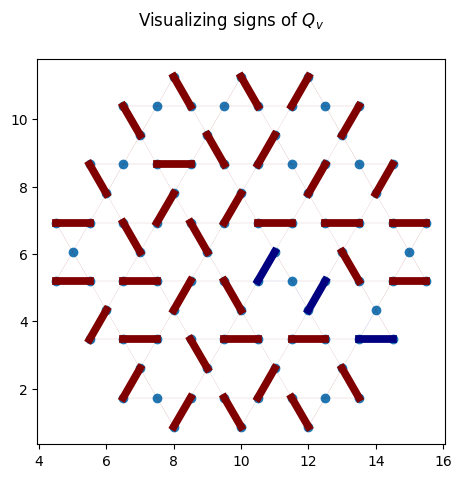

In [343]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [344]:
Qv_results - Q0_results

array([-1.01692834e-03, -1.01127732e-03, -1.01741724e-03, -1.01487174e-03,
       -7.03605135e-04, -6.95947418e-04,  1.30857253e-05, -7.03321320e-04,
       -7.03547603e-04, -1.01729560e-03,  1.30604857e-05, -7.03640665e-04,
       -1.01741319e-03,  1.30606091e-05, -7.03335368e-04,  1.31194449e-05,
       -7.03572294e-04, -7.00129051e-04, -7.02664641e-04, -6.84029644e-04,
        1.30618820e-05, -7.03493524e-04,  1.30943049e-05, -7.03503345e-04,
       -7.03625771e-04, -6.86032664e-04,  1.30759735e-05, -6.95917660e-04,
       -6.94300837e-04, -7.03546388e-04, -9.99998018e+00, -1.01588349e-03,
        1.31566376e-05, -7.00060621e-04, -7.03624836e-04, -1.00874232e-03,
        1.30626843e-05, -7.03276100e-04, -7.01461504e-04, -7.03580828e-04,
       -6.94160713e-04, -6.91991486e-04,  1.31830420e-05, -7.03468874e-04,
       -2.66770538e-03, -1.01348653e-03, -2.62542377e-03, -1.01727679e-03,
       -7.03590889e-04, -7.03206330e-04, -1.01356598e-03,  1.30589426e-05,
        1.30613429e-05, -

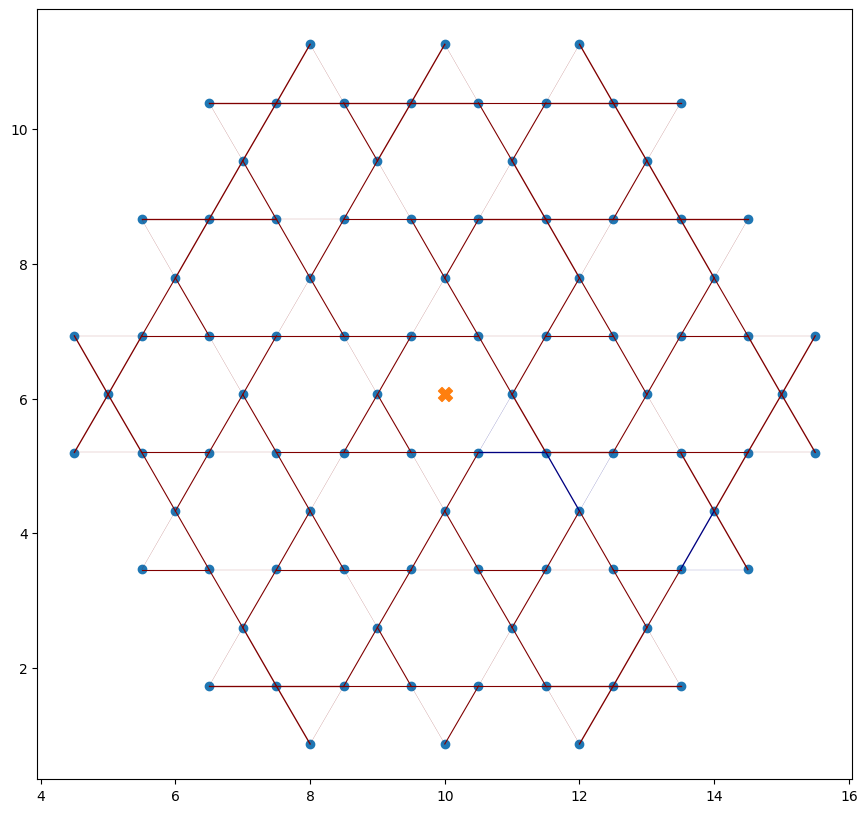

In [345]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')